# Fitting


Most galaxy light profiles can be well described by PSF convolved models like the Sersic profile. PetroFit uses the `astropy` `modeling` and `fitting` sub-modules to provide tools to preform two dimensional fits of galaxy light profiles.  To this end, we use the PetroFit ` PSFModel` class, which applies PSF convolution to and handles oversampling for `astropy` based models.  

In this section, we demonstrate the basics of light profile modeling on a galaxy using a single component Sersic profile. We also demonstrate how the `photometry` and `petrosian` PetroFit sub-models can be used to improve the initial guesses of the Sersic parameters.

## Loading Example Data

The following data is a cutout of a group of bright galaxies in Abell 2744. The original data was aquired by the [Hubble Frontier Fields](https://frontierfields.org) team via the WFC3 instrument in the `F105W` filter and can be dirctly downloaded from the [Mikulski Archive for Space Telescopes](https://archive.stsci.edu/pub/hlsp/frontier/abell2744/images/hst/v1.0/hlsp_frontier_hst_wfc3-60mas_abell2744_f105w_v1.0_drz.fits). 

### Loading Image 
We first use `astropy`'s ``CCDData`` to load the example data and visualize it through `matplotlib`.

In [5]:
from astropy.nddata import CCDData

image = CCDData.read('data/abell_2744_dwarf_galaxy_f105w.fits.gz')

In [6]:
%matplotlib inline

from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['image.origin'] = 'lower'
#plt.rcParams.update({'font.size': 17})

SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def savefig(filename):
    plt.savefig("plots/"+filename, dpi=70, bbox_inches = 'tight', pad_inches = 0.1)

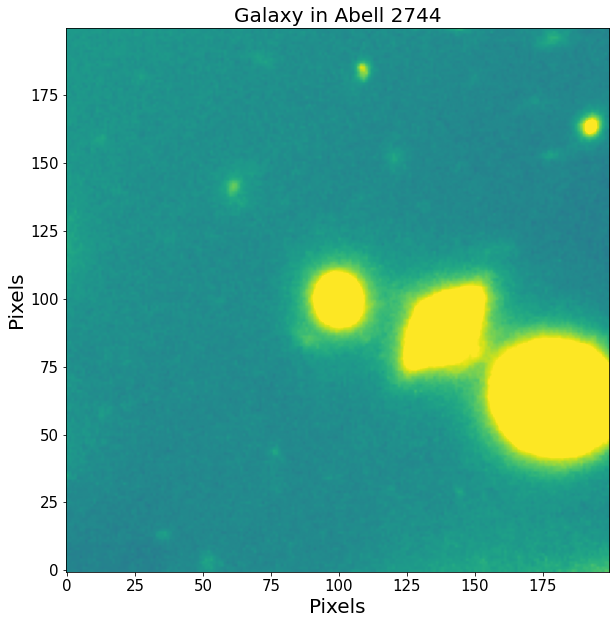

In [7]:
import numpy as np


vmax = 0.05 # Use the image std as max and min of all plots 
vmin = - vmax 

plt.imshow(image.data, vmin=vmin, vmax=vmax)
plt.title("Galaxy in Abell 2744")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

## Make Source Catalog 

We will use the sigma clipped std as a threshold at the segmentation and deblending steps.


In [8]:
from astropy.stats import sigma_clipped_stats
image_mean, image_median, image_stddev = sigma_clipped_stats(image.data, sigma=3)

Here we identity sources in the input image.

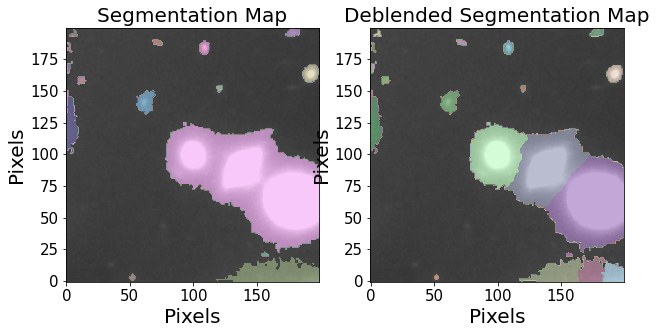

Num of Targets: 19


In [9]:
from petrofit.segmentation import make_catalog, plot_segments

threshold = image_stddev

# Define smoothing kernel
kernel_size = 3
fwhm = 3

# Min Source size (area)
npixels = 4**2


cat, segm, segm_deblend = make_catalog(    
    image.data, 
    threshold=threshold, 
    deblend=True,                 
    kernel_size=kernel_size,                  
    fwhm=fwhm, 
    npixels=npixels,
    contrast=0.00,
    plot=True, vmax=vmax, vmin=vmin
)

plt.show()

# Display source properties
print("Num of Targets:", len(cat))

## Single Source Photometry 


Here we pick a galaxy that can be modeled using a single Sersic model, the galaxy in the middle looks like an elliptical galaxy that can be well described by such a profile. To make sure we selected the right galaxy, we use the `plot_target` function to plot a cutout of the source. 

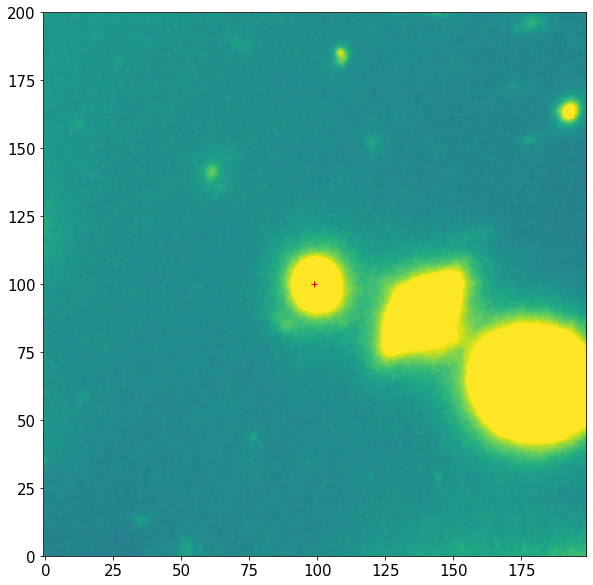

In [10]:
from petrofit.photometry import order_cat
from petrofit.utils import plot_target

# Sort and select object of interest in the catalog
sorted_idx_list = order_cat(cat, key='area', reverse=True)
idx = sorted_idx_list[2] # index 0 is largest 
source = cat[idx]  # get source from the catalog 

plot_target(
    position=(source.maxval_xindex, source.maxval_yindex), 
    image=image.data, 
    size=100, 
    vmax=vmax, 
    vmin=vmin
)

After selecting the source, we define a radius list for the aperture photometry. Once `r_list` is defined, we run the `source_photometry` step.

len(r_list) = 70
19


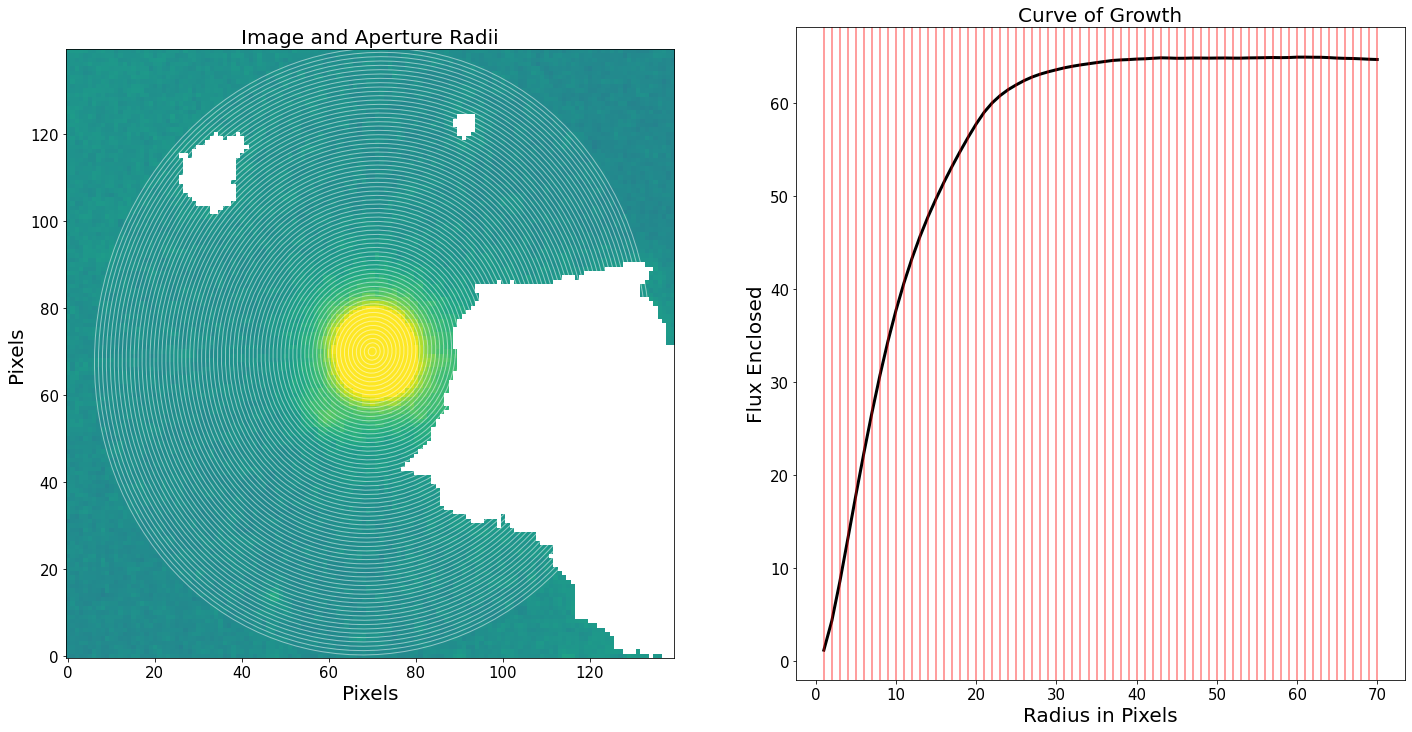

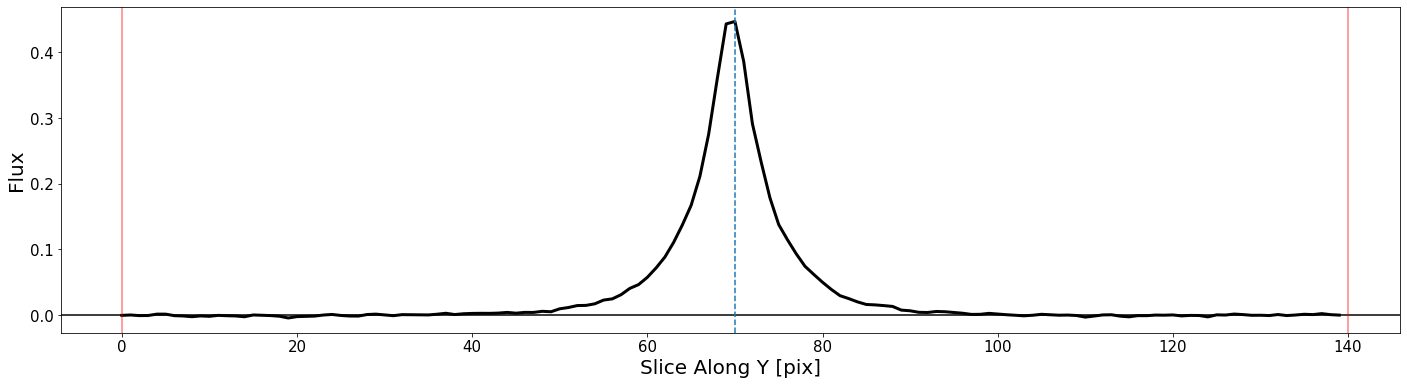

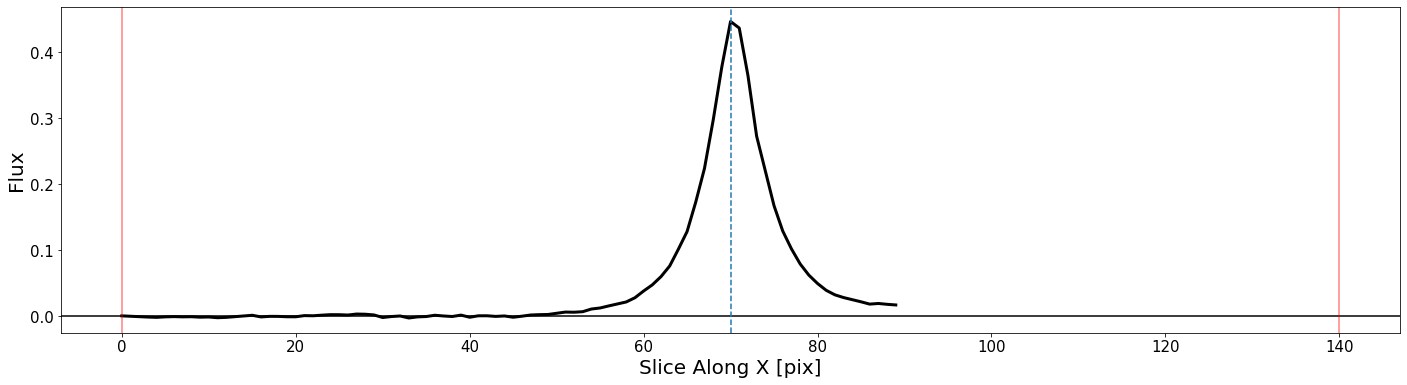

In [11]:
from petrofit.photometry import make_radius_list
from petrofit.photometry import source_photometry

max_pix = 70

r_list = make_radius_list(
    max_pix=max_pix, # Max pixel to go up to
    n=max_pix # the number of radii to produce 
)

print("len(r_list) = {}".format(len(r_list)))


# Photomerty 
flux_arr, area_arr, error_arr = source_photometry(
    
    # Inputs 
    source, # Source (`photutils.segmentation.catalog.SourceCatalog`)
    image.data, # Image as 2D array 
    segm_deblend, # Deblended segmentation map of image
    r_list, # list of aperture radii  
    
    # Options 
    cutout_size=max(r_list)*2, # Cutout out size, set to double the max radius  
    bkg_sub=True, # Subtract background  
    sigma=1, sigma_type='clip', # Fit a 2D plane to pixels within 1 sigma of the mean
    plot=True, vmax=vmax, vmin=vmin, # Show plot with max and min defined above
)


## Petrosian Profile 

 
We use the photometry that we obtained to construct a `Petrosian` profile of the galaxy. This will allow us to estimate the parameters of the galaxies Sersic profile. We also initialize a `PetrosianCorrection` which we can use to estimate the Sersic index (`n`) and `r_eff` (half light radius). The correction grid we use for `PetrosianCorrection` was created specifically for this dataset using the PSF above. 


In [12]:
from petrofit.petrosian import Petrosian, PetrosianCorrection

p = Petrosian(r_list, area_arr, flux_arr)

pc = PetrosianCorrection("example_correction_gid.yaml")

Next we compute and apply the epsilon that produces the correct `r_total_flux` and create a new corrected Petrosian profile (`corrected_p`). To compute `corrected_epsilon` we use the uncorrected ` r_half_light` and `C2080`.

In [13]:
corrected_epsilon = pc.estimate_epsilon(
    p.r_half_light,
    p.concentration_index()[-1]

)

corrected_p = Petrosian(r_list, area_arr, flux_arr, 
                        epsilon=corrected_epsilon)

Galaxies with a high Sersic index (high concentration) have `r_total_flux`s that extend much further than we can possibly measure. If the corrected `r_total_flux` is out of the photometric range (i.e ` r_total_flux > max_pix `), we would be unable to measure the flux at `r_total_flux` (the total flux), which also means that we would be unable to measure the Petrosian radius (`np.nan` is returned). If the corrected ` r_total_flux` is out of range and we feel like the photometry data range goes far out enough to estimate the total flux, we can set `epsilon` to a value that will result in a ` r_total_flux`  equal to the last photometry radius.

Truncation was not needed
total_flux =  64.86016901050724
max_photometry_r =  70.0


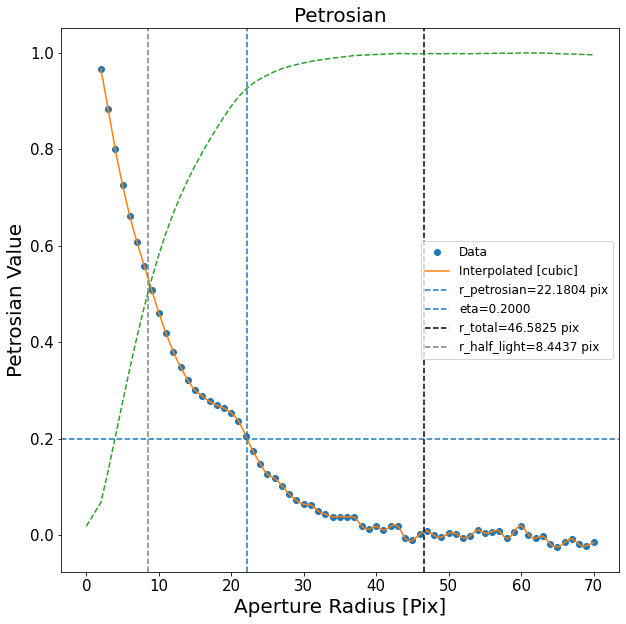

In [14]:
max_photometry_r =  max(corrected_p.r_list)

if corrected_p.total_flux > max_photometry_r:
    print("Truncation was applied")
    truncated_epsilon = max_photometry_r / corrected_p.r_petrosian
    corrected_p.epsilon = truncated_epsilon
else:
    print("Truncation was not needed")

# Print Radii
print('total_flux = ', corrected_p.total_flux)
print('max_photometry_r = ', max_photometry_r)

# Plot Petrosian 
corrected_p.plot(plot_r=True, plot_normalized_flux=True)
plt.show()

## Estimating  Sersic Parameters 

`astropy`’s `Sersic2D` implements this model and allows us to provide initial guesses for the Sersic parameters. Getting good estimates of these parameters is very important because the Levenberg-Marquardt algorithm is sensitive and may return parameters that correspond to a local minium. Because of this, we follow the steps below to estimate the Sersic parameters.

The `Sersic2D` model has the following parameters:

- [**amplitude**: Surface brightness at r_eff.](#Amplitude-at-r_eff)
- [**r_eff**: Effective (half-light) radius.](#Half-Light-Radius-(r_eff))
- [**n**: Sersic Index.](#Sersic-Index)
- [**x_0 and y_0**: x and y position of the center.](#Center-Pixel)
- [**ellip**:  Ellipticity of the profile.](#Ellipticity-and-Elongation)
- [**theta**: Rotation angle in radians, counterclockwise from the positive x-axis.](#Source-Orientation)



### Center Pixel

We can use the `get_source_position` to find the max pixel position of the sourec in the image using the `SourceCatalog` object. Since this center is relative to the image, we save the result in `image_x_0` and `image_y_0`.

In [15]:
from petrofit.segmentation import get_source_position
image_x_0, image_y_0 = get_source_position(source)

print(image_x_0, image_y_0)

99 100


###  Ellipticity and Elongation

We pass the source's `SourceCatalog` object to the `get_source_ellip` and `get_source_elong` functions to find the source's light profile ellipticity and elongation respectively. These values are drived from the segmentation footprint of the source. 

In [16]:
from petrofit.segmentation import get_source_ellip
ellip = get_source_ellip(source)

from petrofit.segmentation import get_source_elong
elong = get_source_elong(source)

print(ellip)
print(elong)

0.09060966969618989
1.0996378196213268


### Source Orientation

We pass the source's `SourceCatalog` object to the `get_source_theta` funciton to find the orientation of the light profile in radians, counterclockwise from the positive x-axis.. In some catalogs, this value is known as the position angle.

In [17]:
from petrofit.segmentation import get_source_theta
theta = get_source_theta(source)

print(theta)

1.3848804796185559


### Sersic Index

The PetroFit `PetrosianCorrection` contains a gird that maps the uncorrected (PSF convolved) Petrosian half-light radius and concentration index to an epsilon value that gives the correct Petrosian radii. This gird can also be used to map the uncorrected half-light radius and concentration index to a Sersic index. 

In [18]:
n = pc.estimate_n(
    p.r_half_light,
    p.concentration_index()[-1]
)

print(n)

1.442891100592536


### Half Light Radius (r_eff)

We use the corrected Petrosian to estimate the half light radius (`r_eff`).

In [19]:
r_eff = corrected_p.r_half_light

print(r_eff)

8.44368873774755


### Amplitude at r_eff

To find the flux at the half-light radius, we fit an elliptical isophot at `r_eff` using `photutils`’s `Ellipse` model. 

In [20]:
from photutils.isophote import EllipseGeometry, Ellipse

# Define EllipseGeometry using ellip and theta
g = EllipseGeometry(image_x_0, image_y_0, 1., ellip, theta)

# Create Ellipse model 
ellipse = Ellipse(image.data, geometry=g)

# Fit isophote at r_eff
iso = ellipse.fit_isophote(r_eff)

# Get flux at r_eff
amplitude = iso.intens

print(amplitude)

0.0784458360389017


## Zoom and Mask Image

Before we fit the image, it is important to mask all nearby sources to avoid interference and zoom in to avoid fitting irrelevant pixels (especially those outside of `r_total_flux`). For this example, we will mask nearby sources using the `masked_segm_image` function that masks pixels using source segmentation footprints and make a zoomed cutout using `astropy`’s `Cutout2D` function. We also make a second cutout (`fitting_image_unmasked`) of the same dimensions as the fitting image, but without masking nearby sources. We will subtract the fitted model from this unmasked image once the fitting is complete. 

We make a cutout of size `cutout_size` centered at he source, as we identified in the [finding center section](#Center-Pixel), and define a new center (`x_0` and `y_0`) that we will use in the `astropy` model. 


In [21]:
max(r_list)*2

140.0

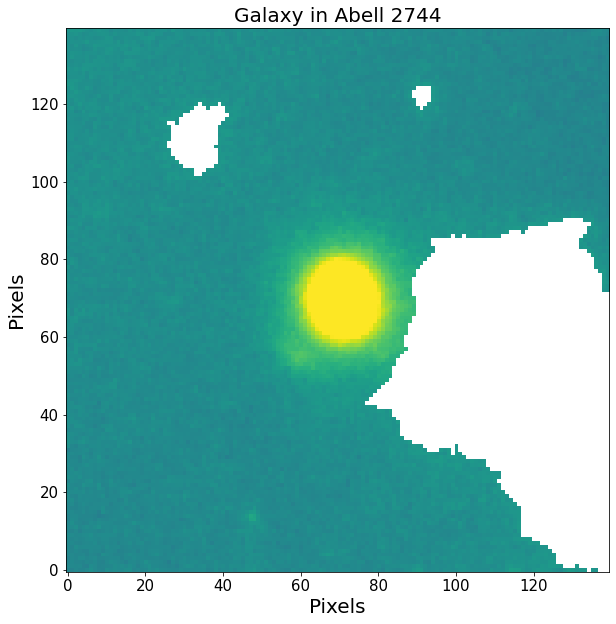

In [22]:
from astropy.nddata import Cutout2D
from petrofit.segmentation import masked_segm_image

# Define cutout size 
cutout_size = max(r_list)*2

# Make an image with all sources masked except `source`
masked_image = masked_segm_image(source, image.data, segm_deblend, fill=None, mask_background=False)

# Make cutouts 
fitting_image = Cutout2D(masked_image, (image_x_0, image_y_0), cutout_size, mode='partial', copy=True)
fitting_image_unmasked = Cutout2D(image.data, (image_x_0, image_y_0), cutout_size, mode='partial', copy=True)

# Define new center 
x_0 = y_0 = cutout_size / 2

# Plot cutout that will be fit 
plt.imshow(fitting_image.data, vmin=vmin, vmax=vmax)
plt.title("Galaxy in Abell 2744")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

## AstroPy Sersic Model

We also define a set of `bounds`,  a dictionary of lower and upper bounds of parameters. Keys are parameter names. The values are a list or a tuple of length 2 giving the desired range for the parameter and a value of `None` means no bounds. For example, we restrain the fitter from exploring half-light radii that are negative by adding  `'r_eff': (0, None)`. We also restrict the center of the model to be within a range (`center_slack`) from the initial guess.

In [23]:
from astropy.modeling import models 

center_slack = 4

sersic_model = models.Sersic2D(
    
        amplitude=amplitude,
        r_eff=r_eff,
        n=n,
        x_0=x_0,
        y_0=y_0,
        ellip=ellip, 
        theta=theta,
    
        bounds = {
            'amplitude': (0., None),
            'r_eff': (0, None),
            'n': (0, 10),
            'ellip': (0, 1),
            'theta': (-2*np.pi, 2*np.pi),
            'x_0': (x_0 - center_slack/2, x_0 + center_slack/2),
            'y_0': (y_0 - center_slack/2, y_0 + center_slack/2),
        },
)

## PSFModel

The `petrofit` `PSFModel` is a `Fittable2DModel` that adds PSF convolution and model to image sampling to `astropy` core models. `PSFModel` makes an image of the underlying model and samples it onto a grid. The model image is then convolved with a PSF if one is provided. Since `PSFModel` is a `Fittable2DModel`, it can be used to fit model images to data images. For example, we wrap an `astropy` `Sersic2D` model in this doc with  `PSFModel`, which produces an oversampled and PSF convolved version of the Sersic profile at each iteration of the Levenberg-Marquardt fitting algorithm.

### PSF 

A Point Spread Function (PSF) describes how light from a point source is distributed on detector due to optical effects such as diffraction. Images or cutouts of stars are good approximations of PSFs because stars are single point sources and their images describe how their light is distributed on the detector. To make cutouts of stars in an image, use the ` astropy.nddata.Cutout2D` function.

The following PSF is a cutout of a star in the Hubble Frontier Fields image of Abell 2744 (same dataset as the example image). Since we will be using the PSF image as a convolution kernel, it is **very important** that following requirements are satisfied:

- The image of the PSF should be at the same resolution as the data.
- The star or PSF is centered in the image.
- The PSF image does not contain other sources. 
- The image is normalized so that the sum of the PSF image near or equal to 1.0. 
- The PSF image should have odd dimensions on each side (because it is a convolution kernel). 


PSF Shape = (51, 51)


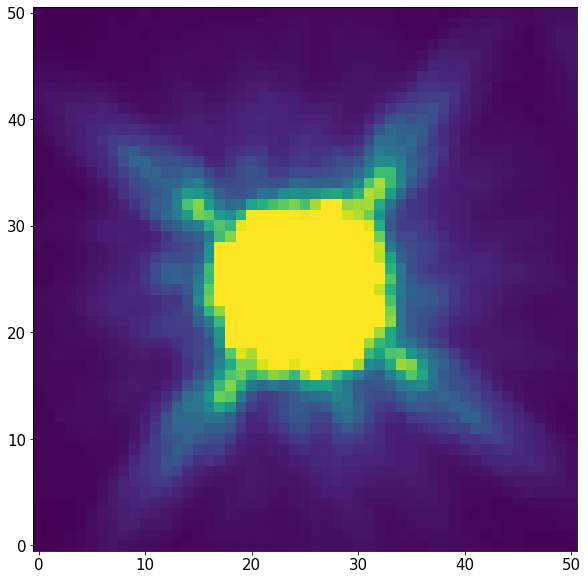

In [24]:
from astropy.io import fits

# Load PSF image (2D array)
PSF = fits.getdata('data/f105w_psf.fits.gz')

# Normalize PSF 
PSF = PSF / PSF.sum()

# Note that the PSF shape is odd on all sides
print("PSF Shape = {}".format(PSF.shape))

# Plot PSF and use vmax and vmin to show difraction spikes
plt.imshow(PSF, vmin=0, vmax=PSF.std()/10)
plt.show()

### Oversampling 

One of the advantages of using `PSFModel` is its ability to sample models onto model images. Sometimes the models have regions that have to be oversampled to produce better estimates of the data.  `PSFModel` can oversample the entire model image or a specific pixel region of the image. The oversampling factor and region can be specified in the `oversample` key word argument when wrapping an `astropy` model or during run time by setting the `PSFModel.oversample` attribute. 

**Disable Oversampling (Defailt)**

To disable oversampling, set the `oversampling` argument or attribute to `None`

In [25]:
# Disable Oversampling
oversample = None 

**Oversample Entire Model Image**

To oversample the image by a factor, you can pass a single integer value. For example:

In [26]:
# Oversample the entire image by a factor of 4
oversample = 4 

**Oversample a Fixed Region**

To oversample a fixed region of finite size, specify the center pixel, the length of the square region and thee oversampling factor. This means passing a tuple of `(center_x, center_y, box_length, oversample_factor)`. For example:

In [27]:
# Replace the pixel values in a box of 
# length 20 cented at (x=50, y=60) with a box of 
# the same size that has been oversampled by a factor of 5 
# i.e (x=50 y=60, box_length=20, oversample_factor=5)

oversample = (50, 60, 20, 5)

**Oversample a Moving Region**

If the model is being fit, the center of the model is likely to move around. To account for this, we can specify the names of the model parameters that define the center of the box that we are interested in oversampling as strings. This means passing a tuple of `(model_param_x, model_param_y, box_length, oversample_factor)`. For example:

In [28]:
# Replace the pixel values in a box of 
# length 20 cented at (x=model.x_0, y=model.y_0) with a box of 
# the same size that has been oversampled by a factor of 5 
# i.e (model.x_0, model.y_0, box_length=20, oversample_factor=5)

oversample = ('x_0', 'y_0', 20, 5)

### Create PetroFit Model

Now that we have an `astropy` model, PSF and oversampling rule, we can create a `PSFModel` model as follows:

In [29]:
from petrofit.models import PSFModel

psf_sersic_model = PSFModel.wrap(sersic_model, psf=PSF, oversample=oversample)

 The `PSFModel` etherates all of the parameters, fixed parameter rules and parameter bounds from the input `astropy` model. Notice that a new parameter, `psf_pa` is added to enable PSF rotation. 

In [30]:
print(psf_sersic_model.param_names)

('amplitude', 'r_eff', 'n', 'x_0', 'y_0', 'ellip', 'theta', 'psf_pa')


In [31]:
print(psf_sersic_model.bounds)

{'amplitude': (0.0, None), 'r_eff': (0.0, None), 'n': (0.0, 10.0), 'x_0': (68.0, 72.0), 'y_0': (68.0, 72.0), 'ellip': (0.0, 1.0), 'theta': (-6.283185307179586, 6.283185307179586), 'psf_pa': (None, None)}


### PSF Rotation 

`PSFModel` has the ability to rotate the PSF image until an optimal rotation angle is found. This is useful for when the PSF comes from a dataset where the orientation of the diffraction spikes are not the same as the image being fit. `psf_pa` is in degrees.

To restrict the bounds of the rotation or disable the PSF rotation, you can set the psf_pa to fixed:

In [32]:
# Limit PSF rotation to -5 to 5 degrees
psf_sersic_model.bounds['psf_pa'] = (-5, 5)

# To disable the PSF rotation, 
# you can set the psf_pa to fixed.
psf_sersic_model.fixed['psf_pa'] = True

### Accessing the Underlying Model 

At any point, a copy of the input model with the same parameter values as the corrosponding `PSFModel` can be accessed using the `PSFModel.model` attribute:

In [33]:
psf_sersic_model.model

<Sersic2D(amplitude=0.07844584, r_eff=8.44368874, n=1.4428911, x_0=70., y_0=70., ellip=0.09060967, theta=1.38488048)>

## Fitting Models

PetroFit uses the Levenberg-Marquardt algorithm to fit parametrized models. To achieve this, it uses `astropy` fitting and provides wrappers to fit models to images. One such function is `fit_model`, which takes any `Fittable2DModel` model and an image to fit, and returns a fitted copy of the model and the `fit_info` dictionary. If the image to be fit contains pixels that are set to `np.nan`, those pixels are ignored by the fitter. The `fit_model` function also allows us to define parameters, such as ` maxiter`, for the `astropy` fitter.

To fit the galaxy we prepared with the `PSFModel` we constructed, we call the `fit_model` as follows: 


In [34]:
%%time

from petrofit.fitting import fit_model

fitted_model, fit_info = fit_model(
    fitting_image.data, psf_sersic_model,
    maxiter=10000,
    epsilon=1.4901161193847656e-08,
    acc=1e-09,
)

CPU times: user 3.55 s, sys: 0 ns, total: 3.55 s
Wall time: 3.55 s


That’s it! The retuned `fitted_model` is a copy of the input model (`psf_sersic_model`) but with the optimized parameter values. We can inspect the parameters of any `astropy` model using the  `print_model_params`:

In [35]:
from petrofit.fitting import print_model_params

print_model_params(fitted_model)

0.0934	amplitude
7.3545	r_eff
1.5406	n
70.8990	x_0
70.4080	y_0
0.1043	ellip
1.9943	theta
0.0000	psf_pa


## Generate Model Image

To generate a model image we use the `model_to_image` utility function. This function allows us to define the center of the model image and the side length of the image. 

In this case we will first create a model image that has the same size as the fitted image and subtract the model image from the unmasked fitting image.

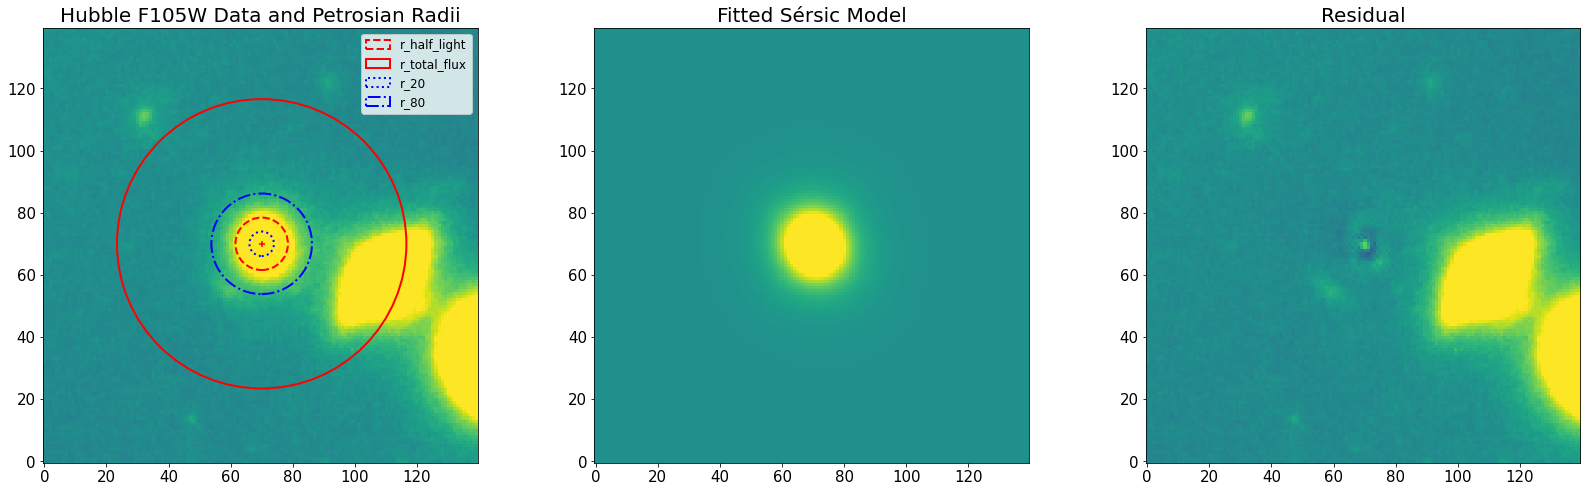

In [36]:
from petrofit.fitting import model_to_image

# Make Model Image 
# ----------------

# Set the size of the model image equal to the fitted image
fitted_image_size = fitting_image.data.shape[0]

# Center the model image at the center of the fitted image
# so the two images cover the same window 
fitted_image_center = fitted_image_size // 2 

# Generate a model image from the model
fitted_model_image = model_to_image(
    x=fitted_image_center, 
    y=fitted_image_center, 
    size=fitted_image_size,
    model=fitted_model
)

# Plot Model Image
# ----------------

fig, ax = plt.subplots(1, 3, figsize=[8*3.5, 8])

# ax[0,0].imshow(fitting_image_unmasked.data, vmin=vmin, vmax=vmax)
# ax[0,0].set_title("Hubble F105W Data")

ax[0].imshow(fitting_image_unmasked.data, vmin=vmin, vmax=vmax)
plt.sca(ax[0])
corrected_p.imshow((x_0, y_0), lw=2)
ax[0].set_title("Hubble F105W Data and Petrosian Radii")
plt.legend()

ax[1].imshow(fitted_model_image, vmin=vmin, vmax=vmax)
ax[1].set_title("Fitted Sérsic Model")

ax[2].imshow(fitting_image_unmasked.data - fitted_model_image, vmin=vmin, vmax=vmax)
ax[2].set_title("Residual")


savefig('single_galaxy_fitted_image.png')
plt.show()

If we want to make a model image that we can subtract from the original data image, we just update the center of the model and generate a model image the same dimensions as the original image.

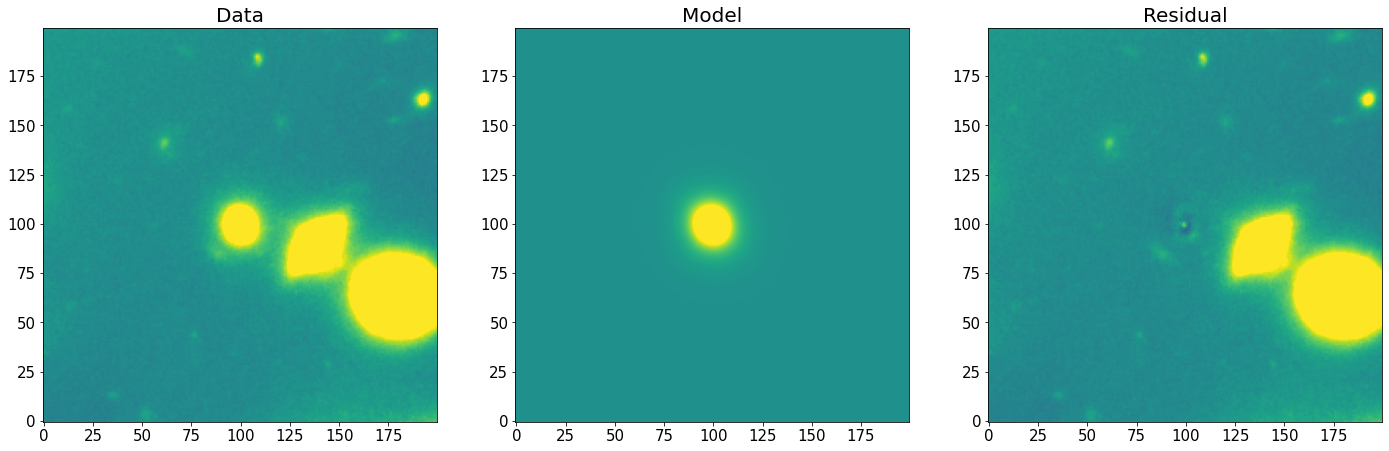

In [37]:
from copy import deepcopy 

# Reposition the Model
# --------------------

# Copy the model before changing the parameters
fitted_model_copy = deepcopy(fitted_model)

# Change the frame of reference from the fitting 
# image to the original data coordinates. 
# Remember that (x_0, y_0) -> (image_x_0, image_y_0) 
fitted_model_copy.x_0 =  image_x_0 + (fitted_model.x_0 - x_0)
fitted_model_copy.y_0 =  image_y_0 + (fitted_model.y_0 - y_0)

# Make Model Image 
# ----------------

# Set the size of the model image equal to the original image
full_fitted_image_size = image.data.shape[0]

# Center the model image at the center of the original image
# so the two images cover the same window 
full_fitted_image_center = full_fitted_image_size // 2 

# Generate a model image from the model
full_fitted_model_image = model_to_image(
    full_fitted_image_center, 
    full_fitted_image_center, 
    full_fitted_image_size, 
    fitted_model_copy
)

# Plot Model Image
# ----------------

fig, ax = plt.subplots(1, 3, figsize=[24, 12])

ax[0].imshow(image.data, vmin=vmin, vmax=vmax)
ax[0].set_title("Data")

ax[1].imshow(full_fitted_model_image, vmin=vmin, vmax=vmax)
ax[1].set_title("Model")

ax[2].imshow(image.data - full_fitted_model_image, vmin=vmin, vmax=vmax)
ax[2].set_title("Residual")

plt.show()

## Estimated vs. Fitted Parameters

In this section we compare the initial estimates that we derived purely from photometry vs. the parameters that were fit to the data. In the printout below, we see the fitted values in the first column and our initial guesses in the second column for each parameter.

In [38]:
assumptions = [
    amplitude,
    r_eff,
    n,
    x_0,
    y_0,
    ellip,
    theta,
    0 # psf_pa
]

print("fit\tassum\tparam_name")
for param_name, param_val, assumption in zip(fitted_model.param_names, fitted_model.parameters, assumptions):
    print("{:0.2f} & {:0.2f} & {}".format(param_val, assumption, param_name))

fit	assum	param_name
0.09 & 0.08 & amplitude
7.35 & 8.44 & r_eff
1.54 & 1.44 & n
70.90 & 70.00 & x_0
70.41 & 70.00 & y_0
0.10 & 0.09 & ellip
1.99 & 1.38 & theta
0.00 & 0.00 & psf_pa


## Galaxy vs. Model Profiles 

Now that we have a model image, we can do photometry and compare the Petrosian measurements of the model to that of the original galaxy image. Since we know the exact postion of the target in the model image and because there are no intruding sourced, we can preform direct photometry using `photometry_step` function.

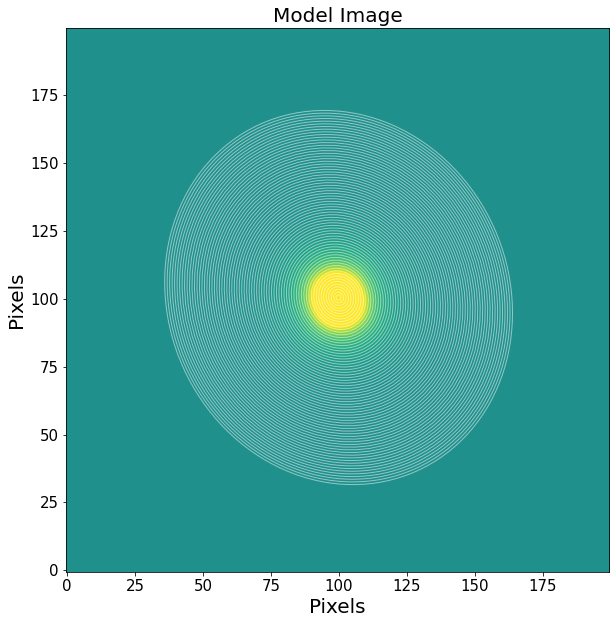

In [39]:
from petrofit.photometry import photometry_step

model_position = (
    fitted_model_copy.x_0.value,
    fitted_model_copy.y_0.value)

model_elong = 1 / (1 - fitted_model_copy.ellip.value)

model_theta = fitted_model_copy.theta.value

model_flux_arr, model_area_arr, model_error_arr = photometry_step(
    position=model_position,
    r_list=r_list, # from the original 
    image=full_fitted_model_image, # Same saize as original image
    elong=model_elong,
    theta=model_theta,
    plot=True, vmin=vmin, vmax=vmax,

)

plt.title("Model Image")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

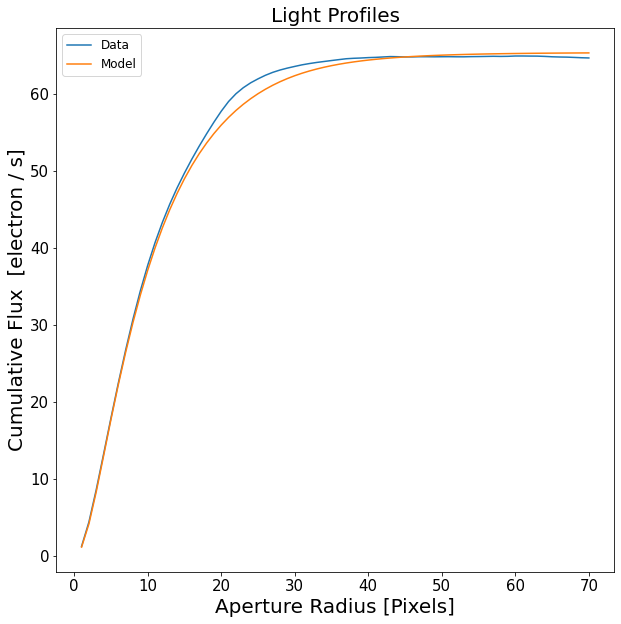

In [40]:
# Plot Light profile 
plt.plot(r_list, flux_arr, label='Data')
plt.plot(r_list, model_flux_arr, label='Model')

plt.title("Light Profiles")
plt.xlabel("Aperture Radius [Pixels]")
plt.ylabel("Cumulative Flux  [{}]".format(image.unit))
plt.legend()
plt.show()

### Petrosian Radii Comparison

We compare the Pertrosian profiles and radii of the two images.

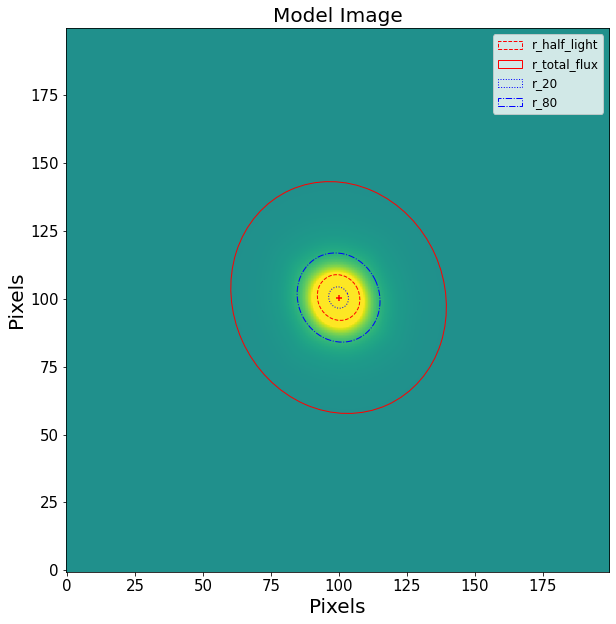

In [41]:
model_p = Petrosian(r_list, model_area_arr, model_flux_arr)

model_corrected_epsilon = pc.estimate_epsilon(
    model_p.r_half_light,
    model_p.concentration_index()[-1]

)

model_corrected_p = Petrosian(
    r_list, model_area_arr, model_flux_arr, 
    epsilon=model_corrected_epsilon
)


# Plot Image 
plt.imshow(full_fitted_model_image, vmax=vmax, vmin=vmin)

model_corrected_p.imshow(
    position=model_position,
    elong=model_elong, 
    theta=model_theta
)

plt.title("Model Image")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.legend()
plt.show()

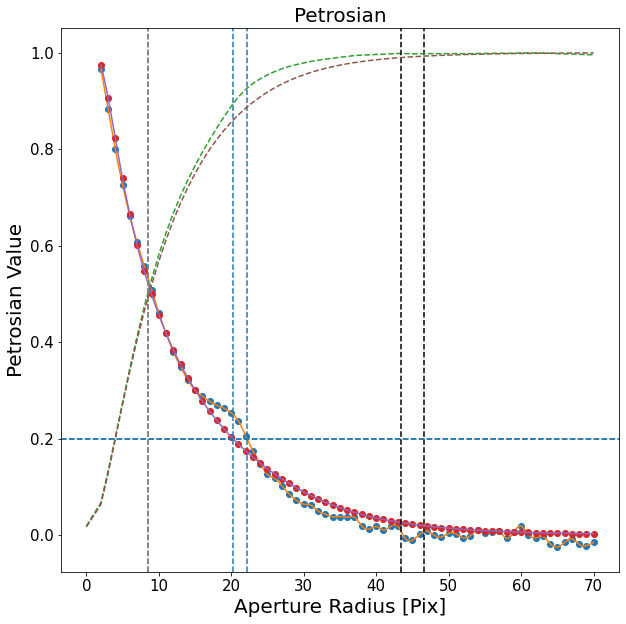

In [42]:
corrected_p.plot(plot_r=True, plot_normalized_flux=True)
model_corrected_p.plot(plot_r=True, plot_normalized_flux=True)

plt.gca().get_legend().remove()
plt.show()

In [43]:
print("Data r_total_flux = {}".format(corrected_p.r_total_flux))
print("Model r_total_flux= {}".format(model_corrected_p.r_total_flux))

Data r_total_flux = 46.582480636895475
Model r_total_flux= 43.37974383741305


In [44]:
print("Data r_half_light = {}".format(corrected_p.r_half_light))
print("Model r_half_light= {}".format(model_corrected_p.r_half_light))

Data r_half_light = 8.44368873774755
Model r_half_light= 8.555711142228445


In [45]:
from petrofit.models import sersic_enclosed
total_model_flux = sersic_enclosed(np.inf, amplitude=fitted_model.amplitude, r_eff=fitted_model.r_eff, n=fitted_model.n, ellip=fitted_model.ellip)
total_model_flux

65.43573396239519

In [46]:
corrected_p.total_flux

64.86016901050724

In [47]:
from petrofit.photometry import flux_to_abmag
flux_to_abmag(corrected_p.total_flux, image.header)

21.73887267845148

In [48]:
flux_to_abmag(float(total_model_flux), image.header)

21.729280423332064

In [49]:
model_corrected_p.total_flux

64.73198191706268

In [50]:
flux_to_abmag(float(model_corrected_p.total_flux), image.header)

21.741020608132885

In [51]:
model_corrected_p.total_flux / total_model_flux 

0.9892451417181789

### Total Flux Comparison

Finally we compare the total Petrosian flux of the data vs the model:

In [52]:
print("Data Corrected Total Flux = {}".format(corrected_p.total_flux * image.unit))
print("Model Corrected Total Flux = {}".format(model_corrected_p.total_flux * image.unit))

Data Corrected Total Flux = 64.86016901050724 electron / s
Model Corrected Total Flux = 64.73198191706268 electron / s


In [53]:
from petrofit.photometry import flux_to_abmag
print("Data Corrected AB mag = {}".format(flux_to_abmag(corrected_p.total_flux, image.header) ))
print("Model Corrected AB mag = {}".format(flux_to_abmag(model_corrected_p.total_flux, image.header) ))

Data Corrected AB mag = 21.73887267845148
Model Corrected AB mag = 21.741020608132885


In [54]:
raw_psf = fits.getdata('data/f105w_psf.fits.gz')

19


No handles with labels found to put in legend.


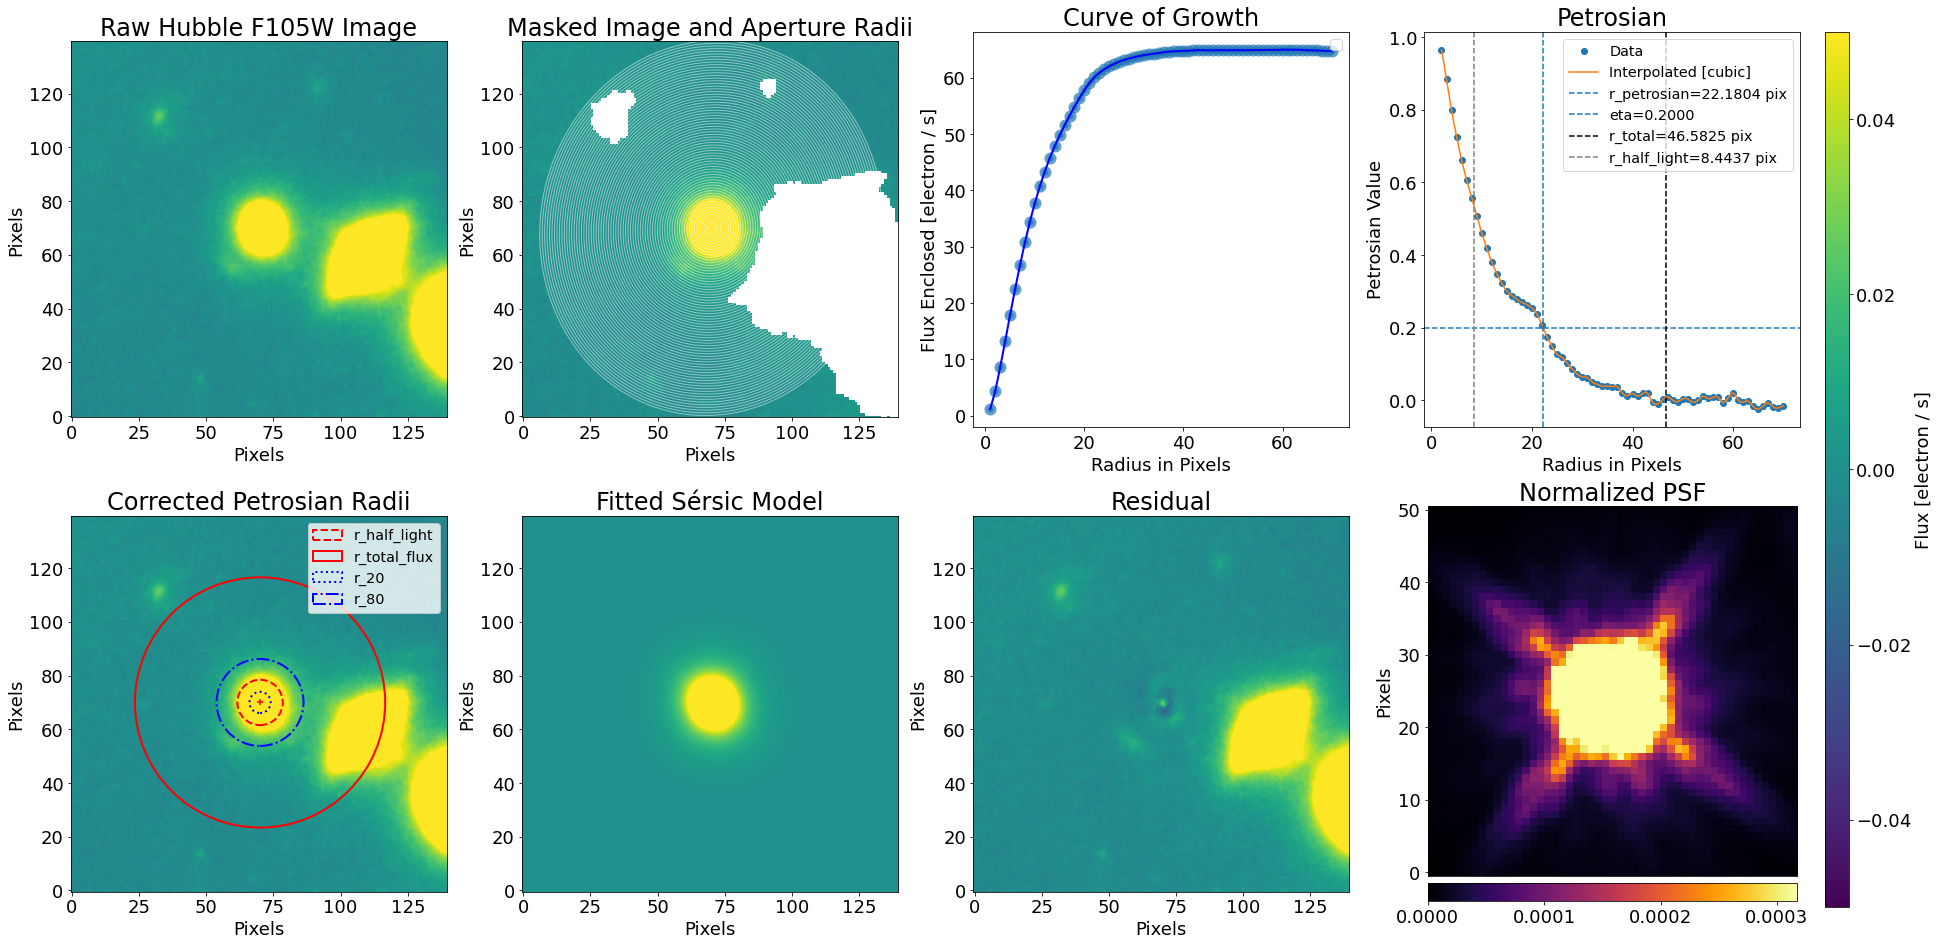

In [55]:
import warnings

import numpy as np

from astropy.nddata import Cutout2D
from astropy.stats import sigma_clipped_stats, sigma_clip
from astropy.utils.exceptions import AstropyWarning

from matplotlib import pyplot as plt

from photutils import  EllipticalAnnulus, EllipticalAperture

from petrofit.segmentation import masked_segm_image
from petrofit.fitting import fit_plane, model_to_image
from petrofit.segmentation import get_source_elong,  get_source_theta, get_source_position

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
factor = 1.2
plt.rc('axes', titlesize=BIGGER_SIZE*factor)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE*factor)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE*factor)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE*factor)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE*factor)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE*factor*2)  # fontsize of the figure title

figsize = [8*4.2, 8*2]
fig, ax = plt.subplots(2, 4, figsize=figsize)
def source_photometry_plot(source, image, segm_deblend, r_list, error=None, cutout_size=None,
                      bkg_sub=False, sigma=3.0, sigma_type='clip', method='exact', mask_background=False,
                      plot=False, vmin=0, vmax=None, ):
    """
    Aperture photometry on a PhotUtils `SourceProperties`.

    Parameters
    ----------
    source : `photutils.segmentation.SourceProperties`
        `SourceProperties` (an entry in a `SourceCatalog`)

    image : 2D array
        Image to preform photometry on.

    segm_deblend : `SegmentationImage`
        Segmentation map of the image.

    r_list : list
        List of aperture radii.

    error : 2D array
        Error image (optional).

    cutout_size : int
        Size of cutout.

    bkg_sub : bool
        If the code should subtract the background using the `sigma` provided.

    sigma : float
        The sigma value used to determine noise pixels. Once the pixels above this value are masked,
        a 2D plane is fit to determine the background. The 2D plane model is then converted into an image and
        subtracted from the cutout of the target source. see the `sigma_type` on how this value will be used.

    sigma_type : {'clip', 'bound'}, optional
        The meaning of the provided sigma.
            * ``'clip'`` (default):
                Uses `astropy.stats.sigma_clipping.sigma_clip` to clip at the provided `sigma` std value.
                Note that `sigma` in this case is the number of stds above the mean.

            * ``'bound'``:
                After computing the mean of the image, clip at `mean - sigma` and `mean + sigma`.
                Note that `sigma` in this case is a value and not the number of stds above the mean.


    method : {'exact', 'center', 'subpixel'}, optional
        The method used to determine the overlap of the aperture on
        the pixel grid.  Not all options are available for all
        aperture types.  Note that the more precise methods are
        generally slower.  The following methods are available:

            * ``'exact'`` (default):
              The the exact fractional overlap of the aperture and
              each pixel is calculated.  The returned mask will
              contain values between 0 and 1.

            * ``'center'``:
              A pixel is considered to be entirely in or out of the
              aperture depending on whether its center is in or out
              of the aperture.  The returned mask will contain
              values only of 0 (out) and 1 (in).

            * ``'subpixel'``
              A pixel is divided into subpixels (see the
              ``subpixels`` keyword), each of which are considered
              to be entirely in or out of the aperture depending on
              whether its center is in or out of the aperture.  If
              ``subpixels=1``, this method is equivalent to
              ``'center'``.  The returned mask will contain values
              between 0 and 1.

    mask_background : bool
        Should background pixels, that are not part of any source in the segmentation map, be included?
        If False, only pixels inside the source's segmentation are unmasked.

    plot : bool
        Show plot of cutout and apertures.

    vmin : int
        Min value for plot.

    vmax : int
        Max value for plot.


    Returns
    -------

    flux_arr, area_arr, error_arr : (numpy.array, numpy.array, numpy.array)
        Tuple of arrays:

            * `flux_arr`: Photometric sum in aperture.

            * `area_arr`: Exact area of aperture.

            * `error_arr`: if error map is provided, error of measurements.
    """

    # Get source geometry
    # -------------------
    position = get_source_position(source)
    elong = get_source_elong(source)
    theta = get_source_theta(source)

    if cutout_size is None:
        cutout_size = np.ceil(max(r_list) * 3)

    cutout_size = int(cutout_size)
    if cutout_size % 2 == 1:
        cutout_size += 1
        
    
    if plot:
        print(source.label)
    
        
    plt.sca(ax[0,0])
    plt.imshow(Cutout2D(image, position, cutout_size, mode='partial', fill_value=np.nan).data, vmin=vmin, vmax=vmax)
    
    plt.title("Raw Hubble F105W Image")
    plt.xlabel("Pixels")
    plt.ylabel("Pixels")

    # Error cutout
    # ------------
    masked_err = None
    if error is not None:
        masked_err = Cutout2D(error, position, cutout_size, mode='partial', fill_value=np.nan).data

    # Image Cutout
    # ------------
    full_masked_image = masked_segm_image(source, image, segm_deblend, fill=np.nan, mask_background=mask_background).data
    masked_nan_image = Cutout2D(full_masked_image, position, cutout_size, mode='partial', fill_value=np.nan)
    masked_image = masked_nan_image.data

    # Cutout for Stats
    # ----------------
    # This cutout has all sources masked
    stats_cutout_size = cutout_size  # max(source.bbox.ixmax - source.bbox.ixmin, source.bbox.iymax - source.bbox.iymin) * 2
    full_bg_image = masked_segm_image(0, image, segm_deblend, fill=np.nan, mask_background=False).data
    masked_stats_image = Cutout2D(full_bg_image, position, stats_cutout_size, mode='partial', fill_value=np.nan).data

    # Subtract Mean Plane
    # -------------------
    if bkg_sub:
        if len(np.where(~np.isnan(masked_stats_image))[0]) > 10:
            with warnings.catch_warnings():

                warnings.simplefilter('ignore', AstropyWarning)
                if sigma_type.lower() == 'clip':
                    fit_bg_image = masked_stats_image
                    fit_bg_image = sigma_clip(fit_bg_image, sigma)

                elif sigma_type.lower() == 'bound':
                    mean, median, std = sigma_clipped_stats(masked_stats_image, sigma=3,
                                                            mask=np.isnan(masked_stats_image.data))

                    fit_bg_image = masked_stats_image
                    fit_bg_image[np.where(fit_bg_image > mean + sigma)] = np.nan
                    fit_bg_image[np.where(fit_bg_image < mean - sigma)] = np.nan
                else:
                    raise ("background image masking sigma type not understood, try 'clip' or 'bound'")

                fitted_model, _ = fit_plane(fit_bg_image)

                # plt.imshow(fit_bg_image, vmax=vmax, vmin=vmin)
                # plt.show()
                # plt.imshow(model_to_image(cutout_size // 2, cutout_size // 2, cutout_size, fitted_model), vmin=vmin, vmax=vmax)
                # plt.show()
                # plt.imshow(masked_image, vmin=vmin, vmax=vmax)
                # plt.show()
                # plt.imshow(masked_image-model_to_image(cutout_size // 2, cutout_size // 2, cutout_size, fitted_model), vmin=vmin, vmax=vmax)
                # plt.show()

                masked_image -= model_to_image(cutout_size // 2, cutout_size // 2, cutout_size, fitted_model)
                if sigma_type.lower() == 'bound':
                    masked_image = np.clip(masked_image, - sigma, np.inf)

        elif plot:
            print("bkg_sub: Not enough datapoints, did not subtract.")

    # Make mask
    # ---------
    mask = np.ones_like(masked_image)
    mask[np.where(np.isnan(masked_image))] = 0
    mask = mask.astype(bool)

    position = np.array(masked_image.data.shape) / 2.

    if plot:
        plt.sca(ax[0,1])

    flux_arr, area_arr, error_arr = photometry_step(position, r_list, masked_image, error=masked_err, mask=mask,
                                                          elong=elong, theta=theta, plot=plot, vmin=vmin, vmax=vmax,
                                                          method=method)
    plt.title("Masked Image and Aperture Radii")
    if plot:
        plt.sca(ax[0,2])
        
        #for r in r_list:
        #    plt.axvline(r, c='gray')
        #plt.axvline(r, c='gray', label='Aperture radii')
        plt.scatter(r_list, flux_arr, linewidth=6, alpha=0.7)
        plt.plot(r_list, flux_arr, c='blue', linewidth=2)
        
        plt.title("Curve of Growth")
        plt.xlabel("Radius in Pixels")
        plt.ylabel("Flux Enclosed [electron / s]")
        plt.legend()
        


# fig, ax = plt.subplots(1,2)

# plt.sca(ax[0])

# elong = get_source_elong(source)
# theta = get_source_theta(source)

# plt.imshow()

# plt.sca(ax[1])
# plt.plot(r_list, flux_arr, linewidth=3)

# for r in r_list:
#     plt.axvline(r, c='r', alpha=0.5)
    
    
# Photomerty 
source_photometry_plot(
    
    # Inputs 
    source, # Source (`photutils.segmentation.catalog.SourceCatalog`)
    image.data, # Image as 2D array 
    segm_deblend, # Deblended segmentation map of image
    r_list, # list of aperture radii  
    
    # Options 
    cutout_size=max(r_list)*2, # Cutout out size, set to double the max radius  
    bkg_sub=True, # Subtract background  
    sigma=1, sigma_type='clip', # Fit a 2D plane to pixels within 1 sigma of the mean
    plot=True, vmax=vmax, vmin=vmin, # Show plot with max and min defined above
)


im = ax[1,0].imshow(fitting_image_unmasked.data, vmin=vmin, vmax=vmax)
plt.sca(ax[1,0])
corrected_p.imshow((x_0, y_0), lw=2)
ax[1,0].set_title("Corrected Petrosian Radii")
plt.legend()
ax[1,0].set_xlabel("Pixels")
ax[1,0].set_ylabel("Pixels")

ax[1,1].imshow(fitted_model_image, vmin=vmin, vmax=vmax)
ax[1,1].set_title("Fitted Sérsic Model")
ax[1,1].set_xlabel("Pixels")
ax[1,1].set_ylabel("Pixels")

ax[1,2].imshow(fitting_image_unmasked.data - fitted_model_image, vmin=vmin, vmax=vmax)
ax[1,2].set_title("Residual")
ax[1,2].set_xlabel("Pixels")
ax[1,2].set_ylabel("Pixels")




plt.sca(ax[0,3])
corrected_p.plot(plot_r=True, plot_normalized_flux=False)
plt.xlabel("Radius in Pixels")



fig.subplots_adjust(right=0.84)
cbar_ax = fig.add_axes([0.85, 0.12, 0.01, 0.76])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('Flux [electron / s]', rotation=90)



plt.sca(ax[1,3])
im2 = plt.imshow(PSF, vmin=0, vmax=PSF.std()/10, cmap='inferno')

ax[1,3].set_title("Normalized PSF")
#ax[1,3].set_xlabel("Pixels")
ax[1,3].set_ylabel("Pixels")
ax[1,3].set_xticks([])
divider = make_axes_locatable(ax[1,3])
cax = divider.append_axes('bottom', size='5%', pad=0.1)

cbar = fig.colorbar(im2, cax=cax, orientation='horizontal')
#cbar.ax.set_xlabel('Normalized Pixel Values', rotation=0)

savefig('single_galaxy.png')
plt.show()

#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title




In [56]:
513.11743/2

256.558715